### Importar Librerías

In [1]:

# trabajar con dataframes
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

# Librerías auxiliares
import json
import ast


### Limpieza de datos

In [2]:
#df_ini = pd.read_csv("DF2022Ene_Jun_3.csv",delimiter=';')
df_ini = pd.read_csv("DF2022Ene_Mar_Top2milAlmacenes.csv",delimiter=';')


In [3]:
# Mostrar los primeros 6 datos
df_ini.head(6)

,creditocodigo,AlmacenCodigo,AntiguedadAlmacen,municipioCodigo,Municipio_Almacen,Departamento_Almacen,CodDANE_DptoAlmacen,Canal,PersonaCodigo,Edad,...,TasaMora,ValorFactura,UltimaCuotaPagada,FechaUltimoPago,plazo,frecuencia,DescripcionEstadoCredito,valorCuota,CantidadCuotas,FechaCreacionCredito
0,21592280,21083,5,132,Cali,Valle Del Cauca,76,Canal fisico,4372294,23,...,0.0190,"95700,00",0,2022-02-28 10:20:08.830,30,30,Pagado,"97518,00",1,2022-01-29 15:35:55.303
1,21592965,16357,6,220,Florencia,Caqueta,18,Canal fisico,1792781,42,...,0.0190,"99901,00",0,2022-05-31 16:35:29.487,120,30,Pagado,"26173,00",4,2022-01-29 15:52:04.737
2,21592825,24327,4,3,Sabaneta,Antioquia,5,Canal fisico,4352106,141,...,0.0088,"155940,00",0,2022-05-05 12:35:39.970,60,15,Pagado,"39849,00",4,2022-01-29 15:48:44.787
3,21593193,16346,6,460,Santander De Quilichao,Cauca,19,Canal fisico,1365043,42,...,0.0190,"154800,00",0,2022-04-13 17:18:33.177,60,30,Pagado,"79613,00",2,2022-01-29 15:57:26.010
4,21592067,38542,2,14,Apartadó,Antioquia,5,Canal fisico,2253109,29,...,0.0190,"340000,00",0,2022-06-07 07:38:15.223,120,30,Pagado,"89075,00",4,2022-01-29 15:30:07.447
5,21592335,1556,11,1,Medellin,Antioquia,5,Canal fisico,3705657,32,...,0.0190,"84900,00",0,2022-05-01 14:19:00.203,120,30,Pagado,"22243,00",4,2022-01-29 15:36:56.087


In [4]:
print('Cantidad de Filas y columnas:',df_ini.shape)
print('Nombre columnas:',df_ini.columns)

Cantidad de Filas y columnas: (744244, 27)
Nombre columnas: Index(['creditocodigo', 'AlmacenCodigo', 'AntiguedadAlmacen',
       'municipioCodigo', 'Municipio_Almacen', 'Departamento_Almacen',
       'CodDANE_DptoAlmacen', 'Canal', 'PersonaCodigo', 'Edad', 'Genero',
       'DiasMora', 'SaldoMora', 'CuotasVencidas', 'ValorCapital',
       'TasaDescuento', 'TasaFinanciacion', 'TasaMora', 'ValorFactura',
       'UltimaCuotaPagada', 'FechaUltimoPago', 'plazo', 'frecuencia',
       'DescripcionEstadoCredito', 'valorCuota', 'CantidadCuotas',
       'FechaCreacionCredito'],
      dtype='object')


In [5]:
#Reemplazar las comas por puntos para los campos numericos
df_ini['SaldoMora'] = df_ini['SaldoMora'].replace(',', '.', regex=True)
df_ini['ValorCapital'] = df_ini['ValorCapital'].replace(',', '.', regex=True)
df_ini['ValorFactura'] = df_ini['ValorFactura'].replace(',', '.', regex=True)
df_ini['valorCuota'] = df_ini['valorCuota'].replace(',', '.', regex=True)


In [6]:
#Reemplazar los valores de Genero de texto, por numero
df_ini['Genero'] = df_ini['Genero'].replace('F', 1, regex=True)
df_ini['Genero'] = df_ini['Genero'].replace('M', 0, regex=True)
df_ini['Genero'] = df_ini['Genero'].replace(np.NaN, 2, regex=True)

In [7]:
df_ini = df_ini.astype({'SaldoMora': 'float64', 'ValorCapital': 'float64', 'ValorFactura':'float64', 'valorCuota':'float64', 'creditocodigo':'object', 'AlmacenCodigo':'object','PersonaCodigo':'object','municipioCodigo':'object','Genero':'uint8','plazo':'float32','frecuencia':'float32','CantidadCuotas':'float32','TasaDescuento':'float32','TasaFinanciacion':'float32','TasaMora':'float32'})
df_ini.dtypes

creditocodigo                object
AlmacenCodigo                object
AntiguedadAlmacen             int64
municipioCodigo              object
Municipio_Almacen            object
Departamento_Almacen         object
CodDANE_DptoAlmacen           int64
Canal                        object
PersonaCodigo                object
Edad                          int64
Genero                        uint8
DiasMora                      int64
SaldoMora                   float64
CuotasVencidas                int64
ValorCapital                float64
TasaDescuento               float32
TasaFinanciacion            float32
TasaMora                    float32
ValorFactura                float64
UltimaCuotaPagada             int64
FechaUltimoPago              object
plazo                       float32
frecuencia                  float32
DescripcionEstadoCredito     object
valorCuota                  float64
CantidadCuotas              float32
FechaCreacionCredito         object
dtype: object

In [8]:
df_ini.describe()

,AntiguedadAlmacen,CodDANE_DptoAlmacen,Edad,Genero,DiasMora,SaldoMora,CuotasVencidas,ValorCapital,TasaDescuento,TasaFinanciacion,TasaMora,ValorFactura,UltimaCuotaPagada,plazo,frecuencia,valorCuota,CantidadCuotas
count,744244.000000,744244.000000,744244.000000,744244.000000,744244.000000,7.442440e+05,744244.000000,7.442440e+05,744244.000000,744244.000000,744244.000000,7.442440e+05,744244.000000,744244.000000,744244.000000,7.442440e+05,744244.000000
mean,5.619429,38.684427,58.884451,0.755938,19.916664,1.196570e+04,0.190252,2.448949e+05,0.012345,0.018978,0.018978,2.085130e+05,0.017002,106.860306,29.507597,6.127531e+04,3.656496
std,2.895840,27.757244,48.585138,0.429868,84.900919,8.261646e+04,0.917627,2.692034e+05,0.007558,0.002700,0.002700,2.238133e+05,0.308773,52.825165,2.664654,5.627822e+04,1.873384
min,1.000000,5.000000,-7920.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000e+04,0.000000,0.000000,0.000000,1.000000e+04,-1.000000,30.000000,15.000000,5.066000e+03,1.000000
25%,3.000000,11.000000,28.000000,1.000000,0.000000,0.000000e+00,0.000000,1.049020e+05,0.010000,0.019000,0.019000,9.000000e+04,0.000000,60.000000,30.000000,3.411500e+04,2.000000
50%,5.000000,41.000000,38.000000,1.000000,0.000000,0.000000e+00,0.000000,1.723640e+05,0.010000,0.020000,0.020000,1.499000e+05,0.000000,120.000000,30.000000,5.017950e+04,4.000000
75%,7.000000,66.000000,61.000000,1.000000,0.000000,0.000000e+00,0.000000,2.846360e+05,0.020000,0.020000,0.020000,2.447000e+05,0.000000,120.000000,30.000000,7.032200e+04,4.000000
max,15.000000,95.000000,156.000000,2.000000,467.000000,3.806566e+06,24.000000,4.213875e+06,0.100000,0.020000,0.020000,3.806566e+06,16.000000,360.000000,30.000000,3.060000e+06,24.000000


### Analisis

#### Asignación de dataset a df

In [9]:
df = df_ini
#df = df[df['FechaCreacionCredito'].str.startswith('2022-05')]

Construir Matriz Usuario-Item

In [10]:
df_matriz1 = pd.DataFrame({'PersonaCodigo': df['PersonaCodigo'], 'AlmacenCodigo': df['AlmacenCodigo']})
df_matriz2 = df_matriz1.drop_duplicates()

In [11]:
# Seleccione las variables categóricas en la matriz de datos
# Use get_dummies para aplicar one hot encoding a las variables categóricas
matriz_usuario_item = pd.get_dummies(df_matriz2['AlmacenCodigo'])

c:\Users\lmendoza\Anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [12]:
matriz_usuario_item

,10,17,35,126,128,194,303,318,319,322,...,44173,44405,44482,44620,44717,44770,44777,44842,44950,45159
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744238,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
744239,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
744240,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
744241,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
#Ensayo 1: No funcionó 
# Construir Matriz de distancias entre clientes
# Calculamos las distancias de Jaccard entre las filas de la matriz 
distancias_condensadas = pdist(matriz_usuario_item, 'jaccard')
# Convertimos las distancias condensadas en una matriz de distancias
distancias_completas = squareform(distancias_condensadas)
# Imprimimos la matriz completa de distancias
print(distancias_completas)

In [45]:
#Ensayo 2: Usando matrices sparse (no funcionó)
from scipy.sparse import csr_matrix
from scipy.spatial.distance import cdist

#Convert the binary matrix to a sparse matrix:
from scipy.sparse import csr_matrix
sparse_matriz_usuario_item = csr_matrix(matriz_usuario_item)

# Assuming you already have the sparse matrix 'sparse_matriz_usuario_item'
# Compute Jaccard distances using cdist
distancias_condensadas = cdist(sparse_matriz_usuario_item, sparse_matriz_usuario_item, metric='jaccard')
print(distancias_condensadas)

In [35]:
#Ensayo 3: Comparando solo 1 fila a la vez con el resto de filas: Si funcionó  pero demora mucho.
from scipy.spatial.distance import jaccard
n_filas = matriz_usuario_item.shape[0]
distancias_jaccard = np.zeros((n_filas,1))
for i in range(n_filas):
    dist = jaccard(matriz_usuario_item.iloc[2], matriz_usuario_item.iloc[i])
    distancias_jaccard[i] = dist 

In [48]:
#Ensayo 4: parallelization 
!pip install joblib
from scipy.spatial.distance import cdist
from joblib import Parallel, delayed
import multiprocessing

In [57]:
# Convert the DataFrame to a numpy array
#data = matriz_usuario_item.to_numpy().astype(np.float32)
data = matriz_usuario_item.astype(bool).to_numpy()
j = int(len(data)/2)

# Define the distance calculation function
def calculate_distance(i, data):
    return cdist(data[i:i+1], data, metric='jaccard')[0]

# Determine the number of CPU cores to utilize
num_cores = multiprocessing.cpu_count()

# Parallelize the distance calculations
distances = Parallel(n_jobs=num_cores)(delayed(calculate_distance)(i, data) for i in range(j))

# Consolidate the results
distances = pd.DataFrame(distances)

print(distances)



KeyboardInterrupt: 

### Construir Matriz de distancias entre almacenes

In [15]:
#1. primer paso del Dataframe de almacenes
#almacenes_1 = df.groupby('AlmacenCodigo').agg(TotalCreditos=('creditocodigo', 'count'),CreditosMujeres=('Genero', 'sum'),cant_clientes=('PersonaCodigo', 'nunique'), edad_clientes=('Edad', 'mean'), Prom_Valorfactura=('ValorFactura', 'mean'),Municipio=('Municipio_Almacen', 'min'),Canal=('Canal', 'min'))
almacenes_1 = df.groupby('AlmacenCodigo').agg(TotalCreditos=('creditocodigo', 'count'),CreditosMujeres=('Genero', 'sum'),cant_clientes=('PersonaCodigo', 'nunique'), edad_clientes=('Edad', 'mean'), Prom_Valorfactura=('ValorFactura', 'mean'))


In [16]:
almacenes_2 = df.groupby('AlmacenCodigo').agg(Municipio=('Municipio_Almacen', 'min'),Canal=('Canal', 'min'))

In [18]:
#2.segundo paso: Calcular las proporciones y eliminar las otras del dataframe de almacenes
almacenes_1['porcentaje_mujeres'] = (almacenes_1['CreditosMujeres'] / almacenes_1['TotalCreditos'])*100 #PROPORCION MUJERES
almacenes_1 = almacenes_1.drop('CreditosMujeres', axis=1)

In [19]:
almacenes_1.head()

,TotalCreditos,cant_clientes,edad_clientes,Prom_Valorfactura,porcentaje_mujeres
AlmacenCodigo,,,,,
10,312,289,54.958333,152443.548077,84.935897
17,311,273,66.810289,138752.916399,85.530547
35,2198,2079,64.958144,238381.802093,82.893540
126,154,126,48.740260,362256.175325,96.103896
128,82,70,53.682927,367140.085366,93.902439


In [20]:
almacenes_1.dtypes
#Aqui el AlmacenCodigo se ha convertido en el indice

TotalCreditos           int64
cant_clientes           int64
edad_clientes         float64
Prom_Valorfactura     float64
porcentaje_mujeres    float64
dtype: object

In [17]:
#df_almacenes.to_csv('df_almacenes.csv', index=False)

In [21]:
# 3er paso convertir las categoricas en numericas. 
# Seleccione las variables categóricas en la matriz de datos
cat = ['Municipio','Canal']
# Use get_dummies para aplicar one hot encoding a las variables categóricas
municipio_bin = pd.get_dummies(almacenes_2['Municipio'])
canal_bin = pd.get_dummies(almacenes_2['Canal'])

In [19]:
# 4to paso: Combine las variables categóricas codificadas con las variables numéricas originales
df_almacenes = pd.concat([almacenes_1,municipio_bin,canal_bin], axis=1)
df_almacenes.head()

,TotalCreditos,cant_clientes,edad_clientes,Prom_Valorfactura,porcentaje_mujeres,Acacias,Aguachica,Aguazul,Anapoima,Andes,...,Villamaria,Villavicencio,Vistahermosa,Yarumal,Yopal,Yumbo,Zarzal,Zipaquira,Canal fisico,Ecommerce
AlmacenCodigo,,,,,,,,,,,,,,,,,,,,,
10,312,289,54.958333,152443.548077,84.935897,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
17,311,273,66.810289,138752.916399,85.530547,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
35,2198,2079,64.958144,238381.802093,82.893540,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
126,154,126,48.740260,362256.175325,96.103896,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
128,82,70,53.682927,367140.085366,93.902439,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [20]:
#6to paso: Calcular la matriz de distancias entre los almacenes
from scipy.spatial.distance import pdist, squareform
import numpy as np
cov = np.cov(df_almacenes.T)
inv_cov = np.linalg.inv(cov)
distances = pdist(df_almacenes, lambda u, v: np.sqrt(np.dot(np.dot((u-v), inv_cov), (u-v).T)))
dist_matrix = squareform(distances)
print(dist_matrix)

/var/folders/vn/gyqsnwt95575hv9b5y4_sg8c0000gn/T/ipykernel_21747/4208409319.py:6: RuntimeWarning: invalid value encountered in sqrt
  distances = pdist(df_almacenes, lambda u, v: np.sqrt(np.dot(np.dot((u-v), inv_cov), (u-v).T)))


[[ 0.          1.45317548  5.94918246 ... 18.85201713  7.16109864
  13.20930445]
 [ 1.45317548  0.          6.22021986 ... 19.02642084  7.02493455
  13.03186512]
 [ 5.94918246  6.22021986  0.         ... 19.82238093  8.53621335
  14.24847288]
 ...
 [18.85201713 19.02642084 19.82238093 ...  0.         19.42969601
  22.52955664]
 [ 7.16109864  7.02493455  8.53621335 ... 19.42969601  0.
  13.68432398]
 [13.20930445 13.03186512 14.24847288 ... 22.52955664 13.68432398
   0.        ]]


In [21]:
#type(dist_matrix)
#dist_matrix.shape
dist_matrix[1]

array([ 1.45317548,  0.        ,  6.22021986, ..., 19.02642084,
        7.02493455, 13.03186512])

In [22]:
#reestablecer el indice
df_almacenes = df_almacenes.reset_index()
df_almacenes.dtypes

AlmacenCodigo          int64
TotalCreditos          int64
cant_clientes          int64
edad_clientes        float64
Prom_Valorfactura    float64
                      ...   
Yumbo                  uint8
Zarzal                 uint8
Zipaquira              uint8
Canal fisico           uint8
Ecommerce              uint8
Length: 180, dtype: object

In [23]:
df_almacenes.head()

,AlmacenCodigo,TotalCreditos,cant_clientes,edad_clientes,Prom_Valorfactura,porcentaje_mujeres,Acacias,Aguachica,Aguazul,Anapoima,...,Villamaria,Villavicencio,Vistahermosa,Yarumal,Yopal,Yumbo,Zarzal,Zipaquira,Canal fisico,Ecommerce
0,10,312,289,54.958333,152443.548077,84.935897,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,17,311,273,66.810289,138752.916399,85.530547,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,35,2198,2079,64.958144,238381.802093,82.893540,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,126,154,126,48.740260,362256.175325,96.103896,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,128,82,70,53.682927,367140.085366,93.902439,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [24]:
#
indices = pd.Series(df_almacenes.index, index=df_almacenes['AlmacenCodigo'])

In [25]:
indices[:10]
#indices.shape

AlmacenCodigo
10     0
17     1
35     2
126    3
128    4
194    5
303    6
318    7
319    8
322    9
dtype: int64

In [26]:
def get_recommendations(cliente):
    almacenes_cliente = df.loc[df['PersonaCodigo'] == cliente, 'AlmacenCodigo'].values
    return almacenes_cliente
    """
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores] 

    # Return the top 10 most similar movies
    return metadata['title'].iloc[movie_indices] """

In [27]:
get_recommendations(465)

array([42771, 25673], dtype=object)

In [78]:
import itertools

def listaAlmacenesSimilares(cliente, dist_matrix=dist_matrix):
    list_alm = df.loc[df['PersonaCodigo'] == cliente, 'AlmacenCodigo'].values
    idx = [indices[alm] for alm in list_alm]
    sim_scores = [list(enumerate(dist_matrix[i])) for i in idx]
    sim_scores = list(itertools.chain.from_iterable(sim_scores))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1])
    #sim_scores = [score for score in sim_scores if score[1] != 0]
    sim_scores = sim_scores[0:11]

    # Get the movie indices
    alm_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return  df_almacenes['AlmacenCodigo'].iloc[alm_indices]

In [41]:
matrixpandas = pd.DataFrame(dist_matrix)

In [45]:
matrixpandas[1923].to_csv('archivo.csv', decimal=',', index=False)

In [79]:
listaAlmacenesSimilares(get_recommendations(465))

1923    42771
1207    25673
1904    42141
1920    42585
1686    37630
1514    32995
213     12913
1925    42829
1000    22788
1913    42370
1966    43596
Name: AlmacenCodigo, dtype: int64

In [15]:
df2 = df = pd.DataFrame(df, columns=['AlmacenCodigo','PersonaCodigo'])
df2.drop_duplicates(['AlmacenCodigo','PersonaCodigo'], inplace=True)
matriz = pd.pivot_table(df2, index='PersonaCodigo', columns='AlmacenCodigo', aggfunc=lambda x: 1, fill_value=0)

KeyboardInterrupt: 

In [126]:
#df['AlmacenCodigo','Canal'].unique()
#almacenes = pd.DataFrame(df['AlmacenCodigo'].unique())
# Agrupar por las columnas ColumnaA y ColumnaB y obtener las combinaciones únicas
combinaciones_unicas = (df.groupby(['AlmacenCodigo', 'Canal'])
                       .apply(lambda x: set(zip(x['AlmacenCodigo'], x['Canal'])))
                       .reset_index(name='Combinaciones'))

print(combinaciones_unicas)

       AlmacenCodigo         Canal            Combinaciones
0                  1  Canal fisico      {(1, Canal fisico)}
1                  7  Canal fisico      {(7, Canal fisico)}
2                  9  Canal fisico      {(9, Canal fisico)}
3                 10  Canal fisico     {(10, Canal fisico)}
4                 16  Canal fisico     {(16, Canal fisico)}
...              ...           ...                      ...
21375          50830  Canal fisico  {(50830, Canal fisico)}
21376          50839  Canal fisico  {(50839, Canal fisico)}
21377          50869  Canal fisico  {(50869, Canal fisico)}
21378          50922  Canal fisico  {(50922, Canal fisico)}
21379          50923  Canal fisico  {(50923, Canal fisico)}

[21380 rows x 3 columns]


In [80]:
#variable binaria para el vector de medias: 1 donde el vector de medias es mayor a 1.5 y cero en otro caso
fn_binaria_mora = lambda x: 1 if x >= 1 else 0
# Aplicar la función lambda a la columna 'col_media' y guardar el resultado en una nueva columna llamada 'col_media_bin'
col_mora_bin = df['DiasMora'].apply(fn_binaria_mora)
col_mora_bin
#Agregar la vble binaria de Mora al df
df['col_mora_bin'] = col_mora_bin
df.head()

,creditocodigo,AlmacenCodigo,AntiguedadAlmacen,municipioCodigo,Municipio_Almacen,Departamento_Almacen,CodDANE_DptoAlmacen,Canal,PersonaCodigo,Edad,...,UltimaCuotaPagada,FechaUltimoPago,plazo,frecuencia,EstadoCreditoCodigo,DescripcionEstadoCredito,valorCuota,CantidadCuotas,FechaCreacionCredito,col_mora_bin
0,21360873,35,15,1,Medellin,Antioquia,5,Canal fisico,399439,45,...,0,2022-08-08,210.0,30.0,2,Pagado,56904.0,7.0,2022-01-12,0
1,21367260,14688,7,136,Armenia,Quindio,63,Canal fisico,436207,49,...,0,2022-03-19,60.0,30.0,2,Pagado,30549.0,2.0,2022-01-13,0
2,21367279,883,13,134,Pereira,Risaralda,66,Canal fisico,294115,39,...,0,2022-05-08,120.0,30.0,2,Pagado,41865.0,4.0,2022-01-13,0
3,21366060,26955,4,137,Dosquebradas,Risaralda,66,Canal fisico,272430,37,...,0,2022-02-15,60.0,30.0,2,Pagado,56572.0,2.0,2022-01-13,0
4,21370194,32677,3,139,Guadalajara de Buga,Valle Del Cauca,76,Canal fisico,512004,39,...,0,2022-01-18,60.0,30.0,2,Pagado,38572.0,2.0,2022-01-13,0


In [81]:
#Construir llave unica para el municipio:
df['Municipio_Almacen_original'] =  df['Municipio_Almacen']
df['Municipio_Almacen'] = df['Departamento_Almacen']+'-'+df['Municipio_Almacen_original']
df.head()

,creditocodigo,AlmacenCodigo,AntiguedadAlmacen,municipioCodigo,Municipio_Almacen,Departamento_Almacen,CodDANE_DptoAlmacen,Canal,PersonaCodigo,Edad,...,FechaUltimoPago,plazo,frecuencia,EstadoCreditoCodigo,DescripcionEstadoCredito,valorCuota,CantidadCuotas,FechaCreacionCredito,col_mora_bin,Municipio_Almacen_original
0,21360873,35,15,1,Antioquia-Medellin,Antioquia,5,Canal fisico,399439,45,...,2022-08-08,210.0,30.0,2,Pagado,56904.0,7.0,2022-01-12,0,Medellin
1,21367260,14688,7,136,Quindio-Armenia,Quindio,63,Canal fisico,436207,49,...,2022-03-19,60.0,30.0,2,Pagado,30549.0,2.0,2022-01-13,0,Armenia
2,21367279,883,13,134,Risaralda-Pereira,Risaralda,66,Canal fisico,294115,39,...,2022-05-08,120.0,30.0,2,Pagado,41865.0,4.0,2022-01-13,0,Pereira
3,21366060,26955,4,137,Risaralda-Dosquebradas,Risaralda,66,Canal fisico,272430,37,...,2022-02-15,60.0,30.0,2,Pagado,56572.0,2.0,2022-01-13,0,Dosquebradas
4,21370194,32677,3,139,Valle Del Cauca-Guadalajara de Buga,Valle Del Cauca,76,Canal fisico,512004,39,...,2022-01-18,60.0,30.0,2,Pagado,38572.0,2.0,2022-01-13,0,Guadalajara de Buga


In [82]:
#Calcular la primera tanda de variables:
df_vbles_n = df.groupby('Municipio_Almacen').agg(TotalCreditos=('Genero', 'count'),creditos_mora=('col_mora_bin', 'sum'),CreditosMujeres=('Genero', 'sum'),cant_clientes=('PersonaCodigo', 'nunique'), edad_clientes=('Edad', 'mean'), Prom_plazo=('plazo', 'mean'), Mediana_plazo=('plazo', 'median'), Prom_Valorfactura=('ValorFactura', 'mean'),Mediana_Valorfactura=('ValorFactura', 'median'))

In [83]:
#Calcular las proporciones y eliminar las otras
df_vbles_n['porcentaje_mora'] = (df_vbles_n['creditos_mora'] / df_vbles_n['TotalCreditos'])*100 #PROPORCION MORA
df_vbles_n['porcentaje_mujeres'] = (df_vbles_n['CreditosMujeres'] / df_vbles_n['TotalCreditos'])*100 #PROPORCION MORA
df_vbles_n = df_vbles_n.drop('creditos_mora', axis=1)
df_vbles_n = df_vbles_n.drop('CreditosMujeres', axis=1)


In [84]:
#Calcular la segunda tanda de variables:
df_dias_mora = df[df['DiasMora'] > 0].groupby('Municipio_Almacen').agg(PromDiasMora=('DiasMora', 'mean'),MedianaDiasMora=('DiasMora', 'median'))
df_municipios = pd.DataFrame(df['Municipio_Almacen'].unique(), columns=['Municipio_Almacen'])
df_dias_mora = pd.merge(df_municipios, df_dias_mora, on='Municipio_Almacen', how='left')
df_dias_mora = df_dias_mora.sort_values('Municipio_Almacen', ascending=True)
df_dias_mora.head()


,Municipio_Almacen,PromDiasMora,MedianaDiasMora
368,Amazonas-Leticia,362.333333,360.0
366,Antioquia-Amaga,321.000000,306.0
159,Antioquia-Amalfi,294.952381,296.0
114,Antioquia-Andes,319.704403,311.0
376,Antioquia-Anorí,231.000000,259.0


In [85]:
#Concatenamos ambas tablas:
df_vbles_n2 = pd.merge(df_vbles_n, df_dias_mora, on='Municipio_Almacen', how='left')
df_vbles_n2.head()

,Municipio_Almacen,TotalCreditos,cant_clientes,edad_clientes,Prom_plazo,Mediana_plazo,Prom_Valorfactura,Mediana_Valorfactura,porcentaje_mora,porcentaje_mujeres,PromDiasMora,MedianaDiasMora
0,Amazonas-Leticia,38,29,31.815789,82.894737,90.0,211252.894737,150000.0,7.894737,71.052632,362.333333,360.0
1,Antioquia-Amaga,80,47,29.975000,108.750000,120.0,147129.237500,120375.0,13.750000,88.750000,321.000000,306.0
2,Antioquia-Amalfi,414,235,32.659420,78.478264,60.0,129981.521739,103500.0,5.072464,92.995169,294.952381,296.0
3,Antioquia-Andes,6220,2485,33.940193,89.739548,90.0,151939.025402,119900.0,5.112540,80.048232,319.704403,311.0
4,Antioquia-Anorí,70,55,33.685714,106.714287,90.0,315177.142857,252500.0,4.285714,84.285714,231.000000,259.0


In [86]:
#Reemplazar los Nan en las medidas de mora
df_vbles_n2['PromDiasMora'] = df_vbles_n2['PromDiasMora'].replace(np.NaN, 0, regex=True)
df_vbles_n2['MedianaDiasMora'] = df_vbles_n2['MedianaDiasMora'].replace(np.NaN, 0, regex=True)
df_vbles_n2.head()

,Municipio_Almacen,TotalCreditos,cant_clientes,edad_clientes,Prom_plazo,Mediana_plazo,Prom_Valorfactura,Mediana_Valorfactura,porcentaje_mora,porcentaje_mujeres,PromDiasMora,MedianaDiasMora
0,Amazonas-Leticia,38,29,31.815789,82.894737,90.0,211252.894737,150000.0,7.894737,71.052632,362.333333,360.0
1,Antioquia-Amaga,80,47,29.975000,108.750000,120.0,147129.237500,120375.0,13.750000,88.750000,321.000000,306.0
2,Antioquia-Amalfi,414,235,32.659420,78.478264,60.0,129981.521739,103500.0,5.072464,92.995169,294.952381,296.0
3,Antioquia-Andes,6220,2485,33.940193,89.739548,90.0,151939.025402,119900.0,5.112540,80.048232,319.704403,311.0
4,Antioquia-Anorí,70,55,33.685714,106.714287,90.0,315177.142857,252500.0,4.285714,84.285714,231.000000,259.0


In [87]:
#Validar si hay vacios
nulos_por_columna = df_vbles_n2.isnull().sum()
print(nulos_por_columna)

Municipio_Almacen       0
TotalCreditos           0
cant_clientes           0
edad_clientes           0
Prom_plazo              0
Mediana_plazo           0
Prom_Valorfactura       0
Mediana_Valorfactura    0
porcentaje_mora         0
porcentaje_mujeres      0
PromDiasMora            0
MedianaDiasMora         0
dtype: int64


In [88]:
#Hallar condicionamiento
df_vbles_n2_numeric = df_vbles_n2.drop('Municipio_Almacen', axis=1)
cond_1 = np.linalg.cond(df_vbles_n2_numeric)
print("Condicionamiento de la matriz:", cond_1)

Condicionamiento de la matriz: 72907.13866250875


In [121]:
#Vector de medias
vector_media = df_vbles_n2_numeric.mean()
vector_media

TotalCreditos             6612.509554
cant_clientes             2916.498938
edad_clientes               34.604537
Prom_plazo                 104.915199
Mediana_plazo              104.808914
Prom_Valorfactura       243739.798078
Mediana_Valorfactura    185957.469214
porcentaje_mora              8.335073
porcentaje_mujeres          75.534719
PromDiasMora               263.891417
MedianaDiasMora            263.722930
dtype: float64

In [98]:
from scipy.spatial.distance import pdist, squareform
import numpy as np

In [99]:
cov = np.cov(df_vbles_n2_numeric.T)
distances = pdist(df_vbles_n2_numeric, lambda u, v: np.sqrt(np.dot(np.dot((u-v), np.linalg.inv(cov)), (u-v).T)))

In [100]:
dist_matrix = squareform(distances)
print(dist_matrix)

[[0.         2.73774571 2.71138567 ... 2.42636574 2.59834287 2.92533977]
 [2.73774571 0.         3.12715958 ... 2.68719103 2.68170435 3.15669204]
 [2.71138567 3.12715958 0.         ... 1.69673361 3.30375599 3.39709882]
 ...
 [2.42636574 2.68719103 1.69673361 ... 0.         1.86273866 2.63206533]
 [2.59834287 2.68170435 3.30375599 ... 1.86273866 0.         2.73389028]
 [2.92533977 3.15669204 3.39709882 ... 2.63206533 2.73389028 0.        ]]


In [120]:
#distancia = pd.DataFrame(dist_matrix)
#distancia.to_csv('distancias.csv', index=False)
#Exportar el data set de municipios
datasetmunicipio = pd.DataFrame(df_vbles_n2)
datasetmunicipio.to_csv('datasetmunicipio.csv', index=False)

In [117]:

df_vbles_n2.to_csv('df_vbles_n2.csv', index=False)

In [102]:
for fila in dist_matrix:
    print(fila)

[ 0.          2.73774571  2.71138567  1.7534566   3.52621048  2.2524657
  4.0353337   2.38971207  5.49885695  2.2797529   3.46122339  2.31661697
  2.19990852  2.62690976  1.77899085  1.99395614  4.49526652  2.39984022
  1.91452945  3.56384277  2.26029351  4.84536132  3.45558468  2.48135973
  7.42754244  2.12549296  4.37569477 10.18481494  3.38851492  2.66313711
  5.24238065  4.16421393  3.67804851  2.61475966  2.53231939  2.51358469
  1.92054245  2.04084689  2.71717067 15.68103277  3.27034873  2.60795607
  3.84003772  2.10489893  8.29268282  3.07929608  1.86544074  3.26723245
  3.66652397  3.38131187  4.1861919   2.36212685  4.22822377  4.92677246
  3.20814014  2.99974663  2.30586835  2.41845708  2.2579578   4.65725204
  4.68003728  2.56874552  2.07367557  5.51093229  2.34245081  1.98283878
  5.02277899  2.20587066  1.93424708  2.16583972  6.40612166  2.19960471
  2.53354514  2.73567449  2.32650195  2.67869784  3.30885325  5.60126331
  2.41686908  3.92243536  4.37315439  2.7180858   2.

In [103]:
# Realizar SVD
U, s, VT = np.linalg.svd(dist_matrix)
### SVD
# Tomar los primeros k vectores singulares para reducir la dimensionalidad de los datos
k = 2
Uk8 = U[:, :k]
Sk8 = np.diag(s[:k])
VTk8 = VT[:k, :]

In [104]:
# Calcular la aproximación de rango k de la matriz
svtk8=np.dot(Sk8, VTk8)
A_k8 = np.dot(Uk8,svtk8)

In [107]:
A_k8.shape

(471, 471)

In [108]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [109]:
# Normalizar la matriz de datos
X = (dist_matrix - np.mean(dist_matrix, axis=0)) / np.std(dist_matrix, axis=0)

In [110]:
# Crear una instancia de la clase PCA y ajustar los datos a ella
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

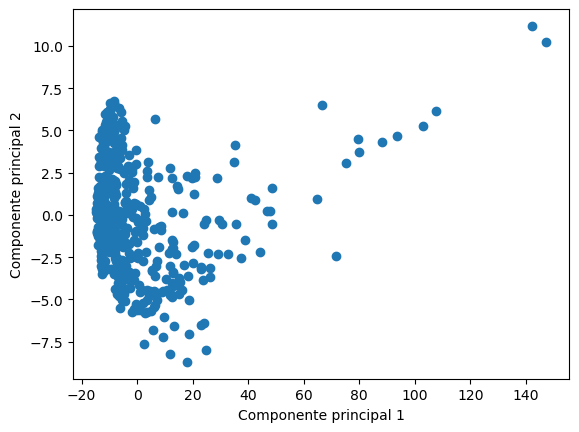

In [111]:
# Transformar los datos originales en los componentes principales
X_pca = pca.transform(X)

# Graficar los datos transformados
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.show()

In [113]:
# Calcular la norma de Frobenius entre las dos matrices
norm_fro8 = np.linalg.norm(X_pca-dist_matrix)
# Mostrar el resultado
print(norm_fro8)




ValueError: operands could not be broadcast together with shapes (471,2) (471,471) 

<AxesSubplot:>

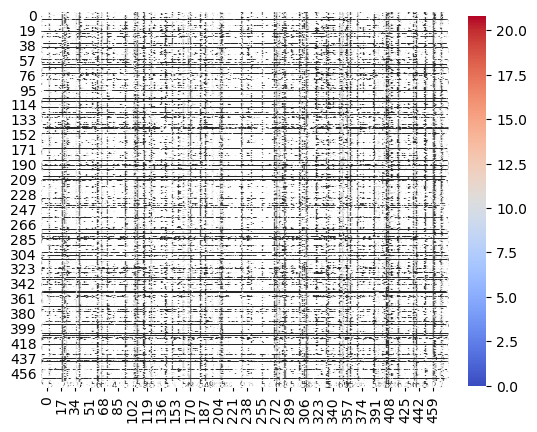

In [101]:
import seaborn as sns
sns.heatmap(dist_matrix, annot=True, cmap='coolwarm', annot_kws={"fontsize":6})

### SVD

In [91]:
# Realizar SVD
U, s, VT = np.linalg.svd(df_vbles_n2_numeric)

In [95]:
# Tomar los primeros k vectores singulares para reducir la dimensionalidad de los datos
k = 6
Uk8 = U[:, :k]
Sk8 = np.diag(s[:k])
VTk8 = VT[:k, :]
# Calcular la aproximación de rango k de la matriz
svtk8=np.dot(Sk8, VTk8)
A_k8 = np.dot(Uk8,svtk8)
cond = np.linalg.cond(A_k8)
print("Condicionamiento de la matriz:", cond)

Condicionamiento de la matriz: 2.3739834638598858e+20


In [42]:


#CantidadClientes
#df_cant_clientes=df.groupby('Municipio_Almacen')['PersonaCodigo'].nunique() #CANTIDAD CLIENTES
#df_cant_clientes.head()
#df_genero_clientes = df.groupby('Municipio_Almacen').agg(CreditosMujeres=('Genero', 'sum'), TotalCreditos=('Genero', 'count'))
#df_genero_clientes['proporcion_mujeres'] = df_genero_clientes['CreditosMujeres'] / df_genero_clientes['TotalCreditos'] #PROPORCION MUJERES
#df_genero_clientes.head()
#df_edad_clientes=df.groupby('Municipio_Almacen')['Edad'].agg(['mean']) #PROMEDIO EDAD CLIENTE
#df_edad_clientes.head()

#df_porcentaje_mora = df.groupby('Municipio_Almacen').agg(creditos_mora=('col_mora_bin', 'sum'), Total=('col_mora_bin', 'count'))
#df_porcentaje_mora['porcentaje_mora'] = (df_porcentaje_mora['creditos_mora'] / df_porcentaje_mora['Total'])*100 #PROPORCION MORA
#df_porcentaje_mora.head()

#df_dias_mora=df[df['DiasMora']>0].groupby('Municipio_Almacen')['DiasMora'].agg(['mean']) #PROMEDIO DIAS MORA
#df_dias_mora.head()

#df_plazo = df.groupby('Municipio_Almacen').agg(Prom_plazo=('plazo', 'mean'), Mediana_plazo=('plazo', 'median'))
#df_plazo.head()

#df_prom_diasMora=df.groupby('Municipio_Almacen')['DiasMora'].agg(['mean']) #Promedio de la edad de clientes
#df_genero_sum=df.groupby('Municipio_Almacen')['Genero'].sum()

#df_genero_clientes.head()

,cant_clientes,Prom_plazo,Mediana_plazo
Municipio_Almacen,,,
Abrego,118,88.013245,90.0
Acacias,3001,103.169945,90.0
Acevedo,16,111.176468,120.0
Aguachica,2919,90.214516,90.0
Aguadas,121,105.252098,120.0


#### Dias y saldo mora analisis

In [93]:
df_mora = df[df['DiasMora']>0]
saldomora = df_mora['SaldoMora']
diasmora = df_mora['DiasMora']
saldomora.describe()

count    1.972800e+05
mean     2.125872e+05
std      2.670550e+05
min      4.700000e+01
25%      7.698250e+04
50%      1.420000e+05
75%      2.362818e+05
max      3.806566e+06
Name: SaldoMora, dtype: float64

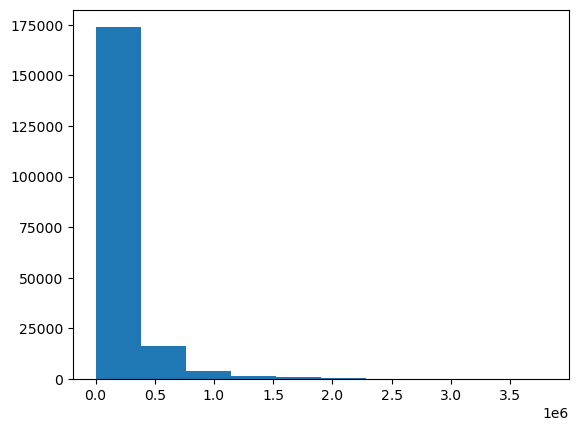

In [94]:
#Histograma
plt.hist(df_mora['SaldoMora'])
plt.show()

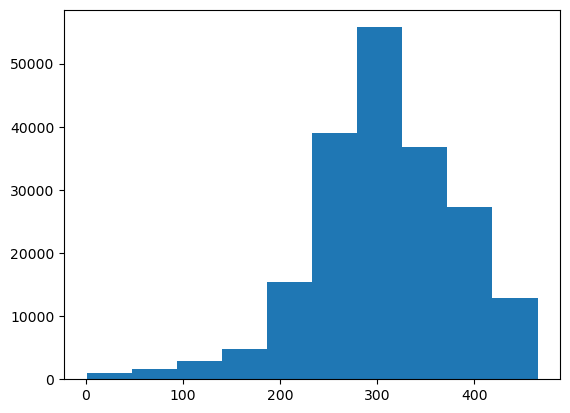

In [95]:
#Histograma
plt.hist(diasmora)
plt.show()

In [14]:
# crear una figura y un conjunto de ejes en blanco
"""
fig, ax = plt.subplots( figsize=(20, 12))
sns.boxplot(x="Departamento_Almacen", y="DiasMora", data=df_dpto, ax=ax)
# Agregamos etiquetas al gráfico
plt.title("Boxplot de DiasMora por Dpto")
plt.xlabel("Departamentos")
plt.ylabel("DiasMora")

plt.xticks(rotation=90)
# Mostramos el gráfico
plt.show()
"""

'\nfig, ax = plt.subplots( figsize=(20, 12))\nsns.boxplot(x="Departamento_Almacen", y="DiasMora", data=df_dpto, ax=ax)\n# Agregamos etiquetas al gráfico\nplt.title("Boxplot de DiasMora por Dpto")\nplt.xlabel("Departamentos")\nplt.ylabel("DiasMora")\n\nplt.xticks(rotation=90)\n# Mostramos el gráfico\nplt.show()\n'

#### Correlacion de todas las variables

<AxesSubplot:>

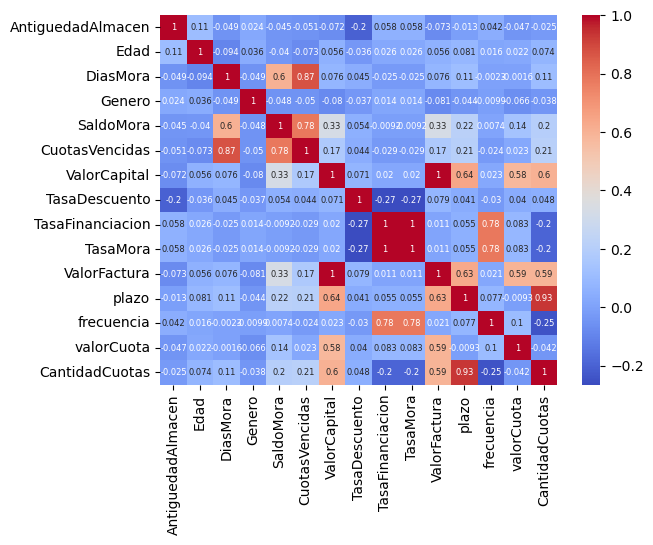

In [96]:
corr_matrix = df[['AntiguedadAlmacen','Edad','DiasMora','Genero',
       'SaldoMora', 'CuotasVencidas', 'ValorCapital',
       'TasaDescuento', 'TasaFinanciacion', 'TasaMora', 'ValorFactura',
       'plazo', 'frecuencia', 'valorCuota', 'CantidadCuotas', ]].corr()
corr_matrix
import seaborn as sns
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', annot_kws={"fontsize":6})

In [97]:
#variable binaria para el vector de medias: 1 donde el vector de medias es mayor a 1.5 y cero en otro caso
fn_binaria_mora = lambda x: 1 if x >= 30 else 0
# Aplicar la función lambda a la columna 'col_media' y guardar el resultado en una nueva columna llamada 'col_media_bin'
col_mora_bin = df['DiasMora'].apply(fn_binaria_mora)
col_mora_bin

0          0
1          0
2          0
3          0
4          0
          ..
3114487    0
3114488    0
3114489    0
3114490    0
3114491    0
Name: DiasMora, Length: 3114492, dtype: int64

#### Variable binaria de mora

In [98]:
#Agregar la vble binaria de Mora al df
df['col_mora_bin'] = col_mora_bin
df.head()

,creditocodigo,AlmacenCodigo,AntiguedadAlmacen,municipioCodigo,Municipio_Almacen,Departamento_Almacen,CodDANE_DptoAlmacen,Canal,PersonaCodigo,Edad,...,UltimaCuotaPagada,FechaUltimoPago,plazo,frecuencia,EstadoCreditoCodigo,DescripcionEstadoCredito,valorCuota,CantidadCuotas,FechaCreacionCredito,col_mora_bin
0,21360873,35,15,1,Medellin,Antioquia,5,Canal fisico,399439,45,...,0,2022-08-08,210.0,30.0,2,Pagado,56904.0,7.0,2022-01-12,0
1,21367260,14688,7,136,Armenia,Quindio,63,Canal fisico,436207,49,...,0,2022-03-19,60.0,30.0,2,Pagado,30549.0,2.0,2022-01-13,0
2,21367279,883,13,134,Pereira,Risaralda,66,Canal fisico,294115,39,...,0,2022-05-08,120.0,30.0,2,Pagado,41865.0,4.0,2022-01-13,0
3,21366060,26955,4,137,Dosquebradas,Risaralda,66,Canal fisico,272430,37,...,0,2022-02-15,60.0,30.0,2,Pagado,56572.0,2.0,2022-01-13,0
4,21370194,32677,3,139,Guadalajara de Buga,Valle Del Cauca,76,Canal fisico,512004,39,...,0,2022-01-18,60.0,30.0,2,Pagado,38572.0,2.0,2022-01-13,0


In [99]:
nulos_por_columna = df.isnull().sum()
print(nulos_por_columna)

creditocodigo                   0
AlmacenCodigo                   0
AntiguedadAlmacen               0
municipioCodigo                 0
Municipio_Almacen               0
Departamento_Almacen            0
CodDANE_DptoAlmacen             0
Canal                           0
PersonaCodigo                   0
Edad                            0
FechaExpedicionDocumento    13683
FechaNacimiento                 2
Genero                          0
DiasMora                        0
SaldoMora                       0
CuotasVencidas                  0
UltimoCompromiso                0
ValorCapital                    0
TasaDescuento                   0
TasaFinanciacion                0
TasaMora                        0
ValorFactura                    0
UltimaCuotaPagada               0
FechaUltimoPago                 0
plazo                           0
frecuencia                      0
EstadoCreditoCodigo             0
DescripcionEstadoCredito        0
valorCuota                      0
CantidadCuotas

### Primera seleccion de variables

In [100]:
#DF con las variables seleccionadas para el analisis (primera seleccion solo con conocimiento del negocio)
df_vbles_1 = df[['Departamento_Almacen','Canal','Genero','ValorFactura','TasaDescuento','TasaFinanciacion','TasaMora','plazo','frecuencia','valorCuota', 'CantidadCuotas']]
df_vbles_1.head()

,Departamento_Almacen,Canal,Genero,ValorFactura,TasaDescuento,TasaFinanciacion,TasaMora,plazo,frecuencia,valorCuota,CantidadCuotas
0,Antioquia,Canal fisico,1,369700.0,0.01,0.019,0.019,210.0,30.0,56904.0,7.0
1,Quindio,Canal fisico,1,59400.0,0.02,0.019,0.019,60.0,30.0,30549.0,2.0
2,Risaralda,Canal fisico,1,159800.0,0.01,0.019,0.019,120.0,30.0,41865.0,4.0
3,Risaralda,Canal fisico,0,110000.0,0.02,0.019,0.019,60.0,30.0,56572.0,2.0
4,Valle Del Cauca,Canal fisico,0,75000.0,0.01,0.019,0.019,60.0,30.0,38572.0,2.0


In [101]:
#Revisar si tenemos nulos
nulos_por_columna = df_vbles_1.isnull().sum()
print(nulos_por_columna)

Departamento_Almacen    0
Canal                   0
Genero                  0
ValorFactura            0
TasaDescuento           0
TasaFinanciacion        0
TasaMora                0
plazo                   0
frecuencia              0
valorCuota              0
CantidadCuotas          0
dtype: int64


In [102]:
#TRANSOFRMAR VBLES CATEGORICAS EN NUMERICAS - MATRIZ DE CORRELACION Y CONDICIONANTE
# Seleccione las variables categóricas en la matriz de datos
categorical_vars_1 = ['Departamento_Almacen', 'Canal']
# Use get_dummies para aplicar one hot encoding a las variables categóricas
data_categorical_1 = pd.get_dummies(df_vbles_1[categorical_vars_1])
# Combine las variables categóricas codificadas con las variables numéricas originales
data_numeric_1 = pd.concat([data_categorical_1, df_vbles_1.drop(categorical_vars_1, axis=1)], axis=1)
#Calcular matriz de correlacion
corr_matrix_1 = data_numeric_1.corr()
#Calcular condicionante
cond_1 = np.linalg.cond(corr_matrix_1)
print("Condicionamiento de la matriz:", cond_1)


Condicionamiento de la matriz: 7.364299097518357e+16


### Sengunda seleccion de variables

In [103]:
#DF con las variables seleccionadas para el analisis
#Probar condicionamiento con estas vbles
#df_vbles_2 = df[['Departamento_Almacen','Canal','Genero','AntiguedadAlmacen','Edad','TasaDescuento','frecuencia','valorCuota', 'CantidadCuotas']]
df_vbles_2 = df[['Departamento_Almacen','Genero','AntiguedadAlmacen','Edad','TasaDescuento','frecuencia','valorCuota', 'CantidadCuotas']]
df_vbles_2.head()

,Departamento_Almacen,Genero,AntiguedadAlmacen,Edad,TasaDescuento,frecuencia,valorCuota,CantidadCuotas
0,Antioquia,1,15,45,0.01,30.0,56904.0,7.0
1,Quindio,1,7,49,0.02,30.0,30549.0,2.0
2,Risaralda,1,13,39,0.01,30.0,41865.0,4.0
3,Risaralda,0,4,37,0.02,30.0,56572.0,2.0
4,Valle Del Cauca,0,3,39,0.01,30.0,38572.0,2.0


In [104]:
#Revisar si tenemos nulos
nulos_por_columna_2 = df_vbles_2.isnull().sum()
print(nulos_por_columna_2)

Departamento_Almacen    0
Genero                  0
AntiguedadAlmacen       0
Edad                    0
TasaDescuento           0
frecuencia              0
valorCuota              0
CantidadCuotas          0
dtype: int64


In [105]:
#TRANSOFRMAR VBLES CATEGORICAS EN NUMERICAS - MATRIZ DE CORRELACION Y CONDICIONANTE
# Seleccione las variables categóricas en la matriz de datos
#categorical_vars_2 = ['Departamento_Almacen', 'Canal']
categorical_vars_2 = ['Departamento_Almacen']
# Use get_dummies para aplicar one hot encoding a las variables categóricas
data_categorical_2 = pd.get_dummies(df_vbles_2[categorical_vars_2])
# Combine las variables categóricas codificadas con las variables numéricas originales
data_numeric_2 = pd.concat([data_categorical_2, df_vbles_2.drop(categorical_vars_2, axis=1)], axis=1)
#Calcular matriz de correlacion
corr_matrix_2 = data_numeric_2.corr()
#Calcular condicionante
cond_2 = np.linalg.cond(corr_matrix_2)
print("Condicionamiento de la matriz:", cond_2)

Condicionamiento de la matriz: 129106536393714.97


In [108]:

data_numeric_2.to_csv('data_numeric_2.csv', index=False)

### Normalización de variables -- NO ES NECESARIO

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Seleccionar las columnas a normalizar
columnas_a_normalizar = ['AntiguedadAlmacen','Edad','TasaDescuento','frecuencia','valorCuota', 'CantidadCuotas']
# Crear un objeto MinMaxScaler
scaler = MinMaxScaler()
# Normalizar cada columna del dataframe
data_numeric_2[columnas_a_normalizar] = scaler.fit_transform(data_numeric_2[columnas_a_normalizar])
data_numeric_2.head()

,Departamento_Almacen_Amazonas,Departamento_Almacen_Antioquia,Departamento_Almacen_Arauca,Departamento_Almacen_Atlantico,Departamento_Almacen_Bogotá D.c.,Departamento_Almacen_Bolivar,Departamento_Almacen_Boyaca,Departamento_Almacen_Caldas,Departamento_Almacen_Caqueta,Departamento_Almacen_Casanare,...,Departamento_Almacen_Tolima,Departamento_Almacen_Valle Del Cauca,Departamento_Almacen_Vichada,Genero,AntiguedadAlmacen,Edad,TasaDescuento,frecuencia,valorCuota,CantidadCuotas
625,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0.285714,0.353535,0.1,1.0,0.015196,0.043478
632,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0.285714,0.434343,0.2,1.0,0.045495,0.304348
633,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0.285714,0.545455,0.1,0.0,0.002013,0.304348
647,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0.142857,0.606061,0.2,1.0,0.028388,0.000000
676,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0.714286,0.434343,0.1,1.0,0.011854,0.043478


In [ ]:
data_numeric_2 = data_numeric_2.astype({'AntiguedadAlmacen': 'float32', 'Edad': 'float32', 'TasaDescuento': 'float32','frecuencia': 'float32', 'valorCuota': 'float32', 'CantidadCuotas': 'float32',})
data_numeric_2.dtypes

Departamento_Almacen_Amazonas                uint8
Departamento_Almacen_Antioquia               uint8
Departamento_Almacen_Arauca                  uint8
Departamento_Almacen_Atlantico               uint8
Departamento_Almacen_Bogotá D.c.             uint8
Departamento_Almacen_Bolivar                 uint8
Departamento_Almacen_Boyaca                  uint8
Departamento_Almacen_Caldas                  uint8
Departamento_Almacen_Caqueta                 uint8
Departamento_Almacen_Casanare                uint8
Departamento_Almacen_Cauca                   uint8
Departamento_Almacen_Cesar                   uint8
Departamento_Almacen_Choco                   uint8
Departamento_Almacen_Cordoba                 uint8
Departamento_Almacen_Cundinamarca            uint8
Departamento_Almacen_Guainia                 uint8
Departamento_Almacen_Guaviare                uint8
Departamento_Almacen_Huila                   uint8
Departamento_Almacen_La Guajira              uint8
Departamento_Almacen_Magdalena 

### SVD

In [106]:
svd_vbles = df_vbles_2.drop(categorical_vars_2, axis=1)
svd_vbles

,Genero,AntiguedadAlmacen,Edad,TasaDescuento,frecuencia,valorCuota,CantidadCuotas
0,1,15,45,0.010,30.0,56904.0,7.0
1,1,7,49,0.020,30.0,30549.0,2.0
2,1,13,39,0.010,30.0,41865.0,4.0
3,0,4,37,0.020,30.0,56572.0,2.0
4,0,3,39,0.010,30.0,38572.0,2.0
...,...,...,...,...,...,...,...
3114487,1,1,19,0.010,30.0,72266.0,2.0
3114488,1,9,32,0.017,30.0,57865.0,4.0
3114489,1,9,32,0.017,30.0,39341.0,4.0
3114490,1,10,32,0.020,30.0,59279.0,4.0


In [107]:
svd_vbles.to_csv('svd_vbles.csv', index=False)

In [91]:
# Realizar SVD
U, s, VT = np.linalg.svd(svd_vbles) 

MemoryError: Unable to allocate 2.86 TiB for an array with shape (626592, 626592) and data type float64

In [77]:
# Tomar los primeros k vectores singulares para reducir la dimensionalidad de los datos
k = 8
Uk8 = U[:, :k] 
Sk8 = np.diag(s[:k]) 
VTk8 = VT[:k, :] 

In [78]:
# Calcular la aproximación de rango k de la matriz 
svtk8=np.dot(Sk8, VTk8)

In [81]:
A_k8 = np.dot(Uk8,np.dot(Sk8, VTk8))

ValueError: shapes (17284,8) and (7,7) not aligned: 8 (dim 1) != 7 (dim 0)

In [293]:
# Calcular la norma de Frobenius entre las dos matrices
norm_fro8 = np.linalg.norm(corr_matrix_2 - A_k8)
# Mostrar el resultado
print(norm_fro8)

5.392228065327271


In [294]:
cond = np.linalg.cond(A_k8)
print("Condicionamiento de la matriz:", cond)

Condicionamiento de la matriz: 3.807603485798338e+19


### Tercera seleccion de variables -- NO ES NECESARIO

In [280]:
#TRANSOFRMAR VBLES CATEGORICAS EN NUMERICAS - MATRIZ DE CORRELACION Y CONDICIONANTE
# Solo usando las vbles numericas
df_vbles_3 = df[['Genero','AntiguedadAlmacen','Edad','TasaDescuento','frecuencia','valorCuota', 'CantidadCuotas']]
#Calcular matriz de correlacion
corr_matrix_3 = df_vbles_3.corr()
#Calcular condicionante
cond_3 = np.linalg.cond(corr_matrix_3)
print("Condicionamiento de la matriz:", cond_3)

Condicionamiento de la matriz: 1.8020507191498207


<AxesSubplot:>

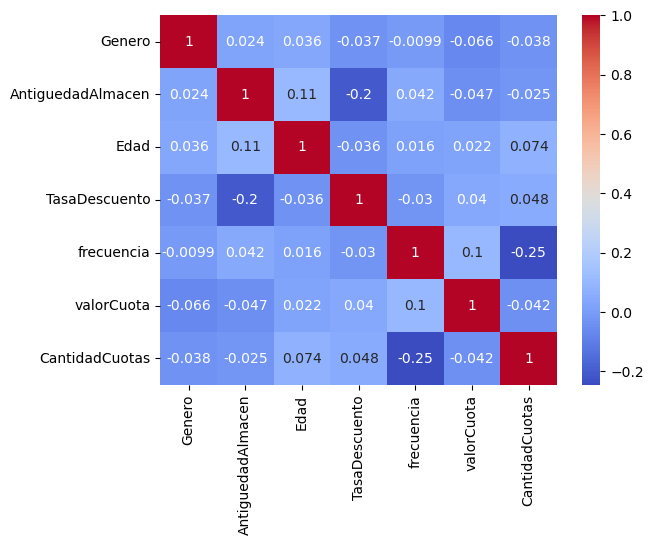

In [265]:
import seaborn as sns
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

In [279]:
df_vbles_3['col_mora_bin'] = col_mora_bin
df_vbles_3.head()

C:\Users\lmendoza\AppData\Local\Temp\ipykernel_11552\2366274170.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vbles_3['col_mora_bin'] = col_mora_bin


,Genero,AntiguedadAlmacen,Edad,TasaDescuento,frecuencia,valorCuota,CantidadCuotas,col_mora_bin
0,1,15,45,0.01,30.0,56904.0,7.0,0
1,1,7,49,0.02,30.0,30549.0,2.0,0
2,1,13,39,0.01,30.0,41865.0,4.0,0
3,0,4,37,0.02,30.0,56572.0,2.0,0
4,0,3,39,0.01,30.0,38572.0,2.0,0


### Primer intento del modelo de regresion 

In [281]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# Cargar datos
X = df_vbles_3
y = col_mora_bin
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
# Ajustar el modelo de regresión logística
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
# Evaluar la precisión del modelo en los conjuntos de entrenamiento y prueba
print("Precisión en el conjunto de entrenamiento: {:.2f}".format(logreg.score(X_train, y_train)))
print("Precisión en el conjunto de prueba: {:.2f}".format(logreg.score(X_test, y_test)))

Precisión en el conjunto de entrenamiento: 0.94
Precisión en el conjunto de prueba: 0.94


### Segundo intento del modelo de regresion

In [25]:
import statsmodels.api as sm

# supongamos que tienes un DataFrame llamado `datos` que contiene las variables independientes y dependiente
X = data_numeric_2
y = col_mora_bin

# agrega una columna constante para el término de intercepto
X = sm.add_constant(X)

# divide los datos en conjuntos de entrenamiento y prueba
n_observaciones = data_numeric_2.shape[0]
n_entrenamiento = int(n_observaciones * 0.7) # 70% de los datos para entrenamiento

X_entrenamiento = X[:n_entrenamiento]
X_prueba = X[n_entrenamiento:]
y_entrenamiento = y[:n_entrenamiento]
y_prueba = y[n_entrenamiento:]

# crea el modelo de regresión logística utilizando los datos de entrenamiento
modelo = sm.Logit(y_entrenamiento, X_entrenamiento)

# ajusta el modelo a los datos de entrenamiento
resultado = modelo.fit()

# haz predicciones para los datos de prueba
predicciones = resultado.predict(X_prueba)

# evalúa la calidad del modelo utilizando medidas de rendimiento
# (aquí puedes agregar tus propias medidas de rendimiento)


Optimization terminated successfully.
         Current function value: 0.182928
         Iterations 8


In [26]:
# imprime el resumen de los resultados
print(resultado.summary())

                           Logit Regression Results                           
Dep. Variable:               DiasMora   No. Observations:              2180144
Model:                          Logit   Df Residuals:                  2180104
Method:                           MLE   Df Model:                           39
Date:                Fri, 28 Apr 2023   Pseudo R-squ.:                 0.06465
Time:                        19:07:05   Log-Likelihood:            -3.9881e+05
converged:                       True   LL-Null:                   -4.2638e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                      -5.0253        nan        nan        nan         nan         nan
Departamento_Almacen_Amazonas              -

### UMBRAL OPTIMO

Umbral óptimo: 0.06
Tasa de aciertos con umbral óptimo: 0.60


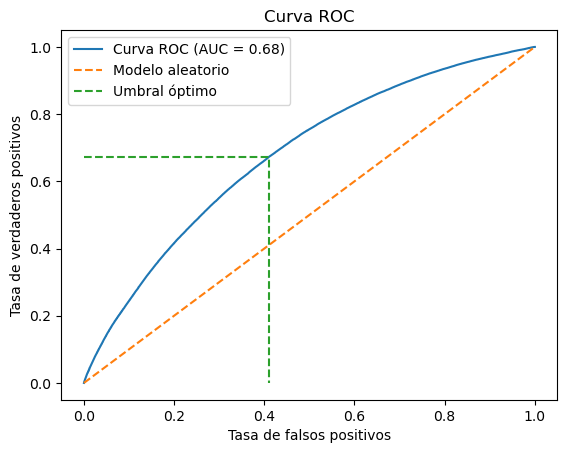

In [27]:
from sklearn.metrics import roc_curve, roc_auc_score


# calcula la curva ROC y el AUC
fpr, tpr, umbrales = roc_curve(y_prueba, predicciones)
auc = roc_auc_score(y_prueba, predicciones)

# encuentra el umbral óptimo
distancias = tpr - fpr
umbral_optimo_idx = np.argmax(distancias)
umbral_optimo = umbrales[umbral_optimo_idx]
print("Umbral óptimo: {:.2f}".format(umbral_optimo))

# calcula la tasa de aciertos utilizando el umbral óptimo
predicciones_binarias = np.where(predicciones >= umbral_optimo, 1, 0)
aciertos = (predicciones_binarias == y_prueba).sum()
tasa_aciertos = aciertos / len(y_prueba)
print("Tasa de aciertos con umbral óptimo: {:.2f}".format(tasa_aciertos))

# traza la curva ROC y muestra el AUC
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label="Curva ROC (AUC = {:.2f})".format(auc))
plt.plot([0, 1], [0, 1], linestyle="--", label="Modelo aleatorio")
plt.plot([0, fpr[umbral_optimo_idx], fpr[umbral_optimo_idx]], [tpr[umbral_optimo_idx], tpr[umbral_optimo_idx], 0], linestyle="--", label="Umbral óptimo")
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.title("Curva ROC")
plt.legend()
plt.show()


### MATRIZ DE CONFUSION

In [ ]:
from sklearn.metrics import confusion_matrix

# Obtener la matriz de confusión
matriz_confusion = confusion_matrix(y_prueba, predicciones)

# Mostrar la matriz de confusión
print(matriz_confusion)

In [282]:
# Accedemos a los coeficientes
coeficientes = logreg.coef_
# Mostramos los coeficientes
print(coeficientes)

[[-1.10989102e-03 -6.79998078e-03 -4.93304492e-02 -1.48285228e-05
  -3.38251978e-02  3.59067454e-07 -2.91544403e-03]]
